## Goal: Using the full dataset, can we say if the ENCODE PLS cCRE promoters 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df = df.loc[df.mixed_samples==False]
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID', 'lab_sample']].drop_duplicates()

In [4]:
# make parent table
files  = expand(proc_cfg(config['lr']['lapa']['pls_int'], od),
                   sample=df['sample'].tolist())
big_df = pd.DataFrame()
for f, s in zip(files, df['sample'].tolist()):
    assert s in f
    temp = pd.read_csv(f, sep='\t')
    temp['sample'] = s
    big_df = pd.concat([big_df, temp], axis=0)

In [5]:
# merge w/ population information
meta_df = load_meta()
meta_df['eur'] = 'Non-European'
meta_df.loc[meta_df['population'].isin(['AJI', 'CEU']), 'eur'] = 'European'
big_df = big_df.merge(meta_df[['sample', 'population',
                               'map_reads_assemblymap', 
                               'ooa', 'eur']], 
                      how='left',
                      on='sample')

In [6]:
# count number of known / novel per sample
gb_cols = ['int_pls', 'sample', 'ooa', 'eur',
           'population', 'map_reads_assemblymap']
keep_cols = gb_cols+['rid']
big_df = big_df[keep_cols].groupby(gb_cols).nunique().reset_index().rename({'rid':'n_tss'}, axis=1)
big_df.head()

,int_pls,sample,ooa,eur,population,map_reads_assemblymap,n_tss
0,False,AJI1,OOA,European,AJI,12033035.0,2391
1,False,AJI2,OOA,European,AJI,13693804.0,2002
2,False,AJI3,OOA,European,AJI,14486506.0,3915
3,False,AJI4,OOA,European,AJI,9599380.0,1910
4,False,AJI5,OOA,European,AJI,19455494.0,5000


In [7]:
# first, number of tss split by known and novel per million mapped reads
big_df['norm_n_tss'] = (big_df.n_tss/(big_df.map_reads_assemblymap/1e6))
big_df['novelty'] = 'Novel'
big_df.loc[big_df.int_pls==True, 'novelty'] = 'Known'

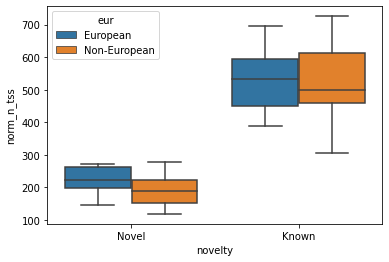

In [8]:
# c_dict, order = gt
ax = sns.boxplot(data=big_df, x='novelty',
                 y='norm_n_tss',
                 hue='eur')

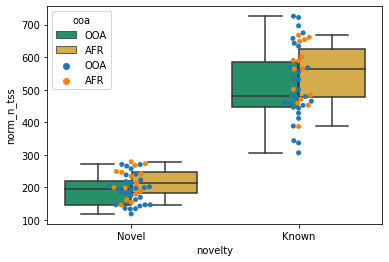

In [17]:
c_dict, order = get_afr_colors()
ax = sns.boxplot(data=big_df, x='novelty',
                 y='norm_n_tss',
                 hue='ooa',
                 palette=c_dict,
                 saturation=1)
c_dict, order = get_afr_colors()
ax = sns.swarmplot(data=big_df, x='novelty',
                 y='norm_n_tss',
                 hue='ooa', ax=ax)

In [18]:
big_df.head()

,int_pls,sample,ooa,eur,population,map_reads_assemblymap,n_tss,norm_n_tss,novelty
0,False,AJI1,OOA,European,AJI,12033035.0,2391,198.702987,Novel
1,False,AJI2,OOA,European,AJI,13693804.0,2002,146.197507,Novel
2,False,AJI3,OOA,European,AJI,14486506.0,3915,270.251502,Novel
3,False,AJI4,OOA,European,AJI,9599380.0,1910,198.971184,Novel
4,False,AJI5,OOA,European,AJI,19455494.0,5000,256.996815,Novel


In [19]:
big_df.to_csv('250327_lapa_full_pls_support.tsv', sep='\t')